In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("./input"))

# Any results you write to the current directory are saved as output.

['questions-feature-extracted', 'questionsnopreprocessing', 'nlpword2vecembeddingspretrained']


In [12]:
from fuzzywuzzy import fuzz
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
stopword=nltk.corpus.stopwords.words('english')
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [3]:
import gensim
from gensim.models import Word2Vec
    
model = gensim.models.KeyedVectors.load_word2vec_format('../input/nlpword2vecembeddingspretrained/GoogleNews-vectors-negative300.bin', binary=True)

**Here is the data without any pre processing**

In [6]:
df=pd.read_csv('./input/data_orignal.csv')
print(df.info())
print("data shape : ",df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
Unnamed: 0      10000 non-null int64
id              10000 non-null int64
qid1            10000 non-null int64
qid2            10000 non-null int64
question1       10000 non-null object
question2       10000 non-null object
is_duplicate    10000 non-null int64
dtypes: int64(5), object(2)
memory usage: 547.0+ KB
None
data shape :  (10000, 7)


In [8]:
df.head(10)

,Unnamed: 0,id,qid1,qid2,question1,question2,is_duplicate
0,0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
5,5,5,11,12,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1
6,6,6,13,14,Should I buy tiago?,What keeps childern active and far from phone ...,0
7,7,7,15,16,How can I be a good geologist?,What should I do to be a great geologist?,1
8,8,8,17,18,When do you use シ instead of し?,"When do you use ""&"" instead of ""and""?",0
9,9,9,19,20,Motorola (company): Can I hack my Charter Moto...,How do I hack Motorola DCX3400 for free internet?,0


**Here is the data after doing feature extraction**

In [9]:
df=pd.read_csv('./input/data.csv')
print(df.info())
print("data shape : ",df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 21 columns):
Unnamed: 0               10000 non-null int64
Unnamed: 0.1             10000 non-null int64
id                       10000 non-null int64
qid1                     10000 non-null int64
qid2                     10000 non-null int64
question1                9999 non-null object
question2                10000 non-null object
is_duplicate             10000 non-null int64
wmdistance               10000 non-null float64
len_q1                   10000 non-null int64
len_q2                   10000 non-null int64
diff_len                 10000 non-null int64
len_char_q1              10000 non-null int64
len_char_q2              10000 non-null int64
len_word_q1              10000 non-null int64
len_word_q2              10000 non-null int64
common_words             10000 non-null int64
fuzz_qratio              10000 non-null int64
fuzz_WRatio              10000 non-null int64
fuzz_partial_ra

In [10]:
df.head()

,Unnamed: 0,Unnamed: 0.1,id,qid1,qid2,question1,question2,is_duplicate,wmdistance,len_q1,...,diff_len,len_char_q1,len_char_q2,len_word_q1,len_word_q2,common_words,fuzz_qratio,fuzz_WRatio,fuzz_partial_ratio,fuzz_token_sort_ratio
0,0,0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,0.109718,65,...,9,19,19,14,12,11,93,95,100,93
1,1,1,1,3,4,What is the story of Kohinoor KohiNoor Diamond,What would happen if the Indian government sto...,0,0.345145,46,...,-37,17,25,8,13,4,64,86,70,62
2,2,2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,0.241202,72,...,14,24,23,14,10,4,54,63,53,66
3,3,3,3,7,8,Why am I mentally very lonely How can I solve it,Find the remainder when math2324math is divide...,0,0.552092,48,...,-7,18,18,11,9,0,35,35,31,35
4,4,4,4,9,10,Which one dissolve in water quikly sugar salt ...,Which fish would survive in salt water,0,0.312057,73,...,35,23,17,13,7,4,45,86,55,47


In [13]:
df.describe()

,Unnamed: 0,Unnamed: 0.1,id,qid1,qid2,is_duplicate,wmdistance,len_q1,len_q2,diff_len,len_char_q1,len_char_q2,len_word_q1,len_word_q2,common_words,fuzz_qratio,fuzz_WRatio,fuzz_partial_ratio,fuzz_token_sort_ratio
count,10000.000000,10000.00000,10000.00000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,2599.500000,4999.50000,4999.50000,9612.395200,9602.829100,0.371100,inf,57.902700,58.296100,-0.393400,18.805300,18.761400,10.940600,11.148600,4.864000,62.016800,76.280500,65.502000,63.943700
std,1604.241444,2886.89568,2886.89568,5602.942387,5609.387868,0.483123,NaN,29.453125,34.137316,32.692579,3.785951,3.933372,5.459529,6.537797,3.013605,18.347386,15.398699,17.008213,16.871965
min,0.000000,0.00000,0.00000,1.000000,2.000000,0.000000,0.000000e+00,0.000000,10.000000,-985.000000,0.000000,6.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1249.750000,2499.75000,2499.75000,4750.500000,4738.000000,0.000000,1.859036e-01,38.000000,37.000000,-11.000000,16.000000,16.000000,7.000000,7.000000,3.000000,47.000000,66.000000,51.000000,51.000000
50%,2499.500000,4999.50000,4999.50000,9570.000000,9541.000000,0.000000,2.574164e-01,50.000000,49.000000,0.000000,18.000000,18.000000,10.000000,9.000000,5.000000,61.000000,84.000000,65.000000,63.000000
75%,3749.250000,7499.25000,7499.25000,14451.500000,14454.500000,1.000000,3.364183e-01,70.000000,69.000000,12.000000,21.000000,21.000000,13.000000,13.000000,6.000000,77.000000,86.000000,79.000000,77.000000
max,5999.000000,9999.00000,9999.00000,19412.000000,19413.000000,1.000000,inf,359.000000,1130.000000,303.000000,43.000000,41.000000,65.000000,228.000000,24.000000,100.000000,100.000000,100.000000,100.000000


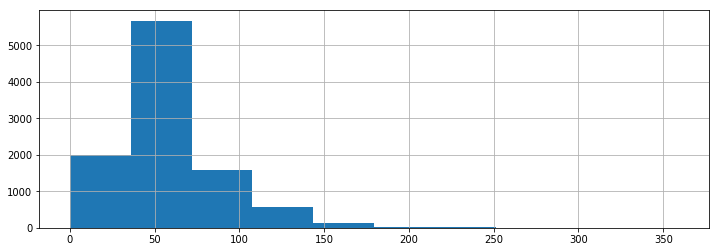

In [17]:
df['len_q1'].hist(figsize=(12, 4));

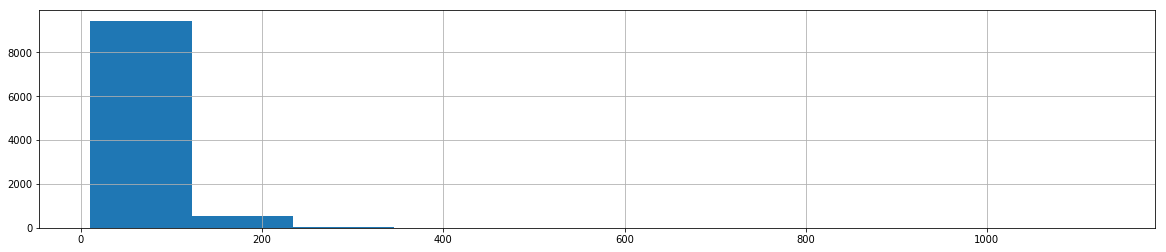

In [19]:
df['len_q2'].hist(figsize=(20, 4));

In [20]:
for _ in df.columns:
    print("The number of null values in:{} == {}".format(_, df[_].isnull().sum())) # will count the number of null values

The number of null values in:Unnamed: 0 == 0
The number of null values in:Unnamed: 0.1 == 0
The number of null values in:id == 0
The number of null values in:qid1 == 0
The number of null values in:qid2 == 0
The number of null values in:question1 == 1
The number of null values in:question2 == 0
The number of null values in:is_duplicate == 0
The number of null values in:wmdistance == 0
The number of null values in:len_q1 == 0
The number of null values in:len_q2 == 0
The number of null values in:diff_len == 0
The number of null values in:len_char_q1 == 0
The number of null values in:len_char_q2 == 0
The number of null values in:len_word_q1 == 0
The number of null values in:len_word_q2 == 0
The number of null values in:common_words == 0
The number of null values in:fuzz_qratio == 0
The number of null values in:fuzz_WRatio == 0
The number of null values in:fuzz_partial_ratio == 0
The number of null values in:fuzz_token_sort_ratio == 0


In [72]:
print(df[(df['wmdistance']>0.1) & (df['is_duplicate']==1)]['id'].count())
print(df[(df['wmdistance']>0.2) & (df['is_duplicate']==1)]['id'].count())
print(df[(df['wmdistance']>0.25) & (df['is_duplicate']==1)]['id'].count())
print(df[(df['wmdistance']>0.3) & (df['is_duplicate']==1)]['id'].count())
print(df[(df['wmdistance']>0.4) & (df['is_duplicate']==1)]['id'].count())
print(df[(df['wmdistance']>0.5) & (df['is_duplicate']==1)]['id'].count())

3301
2116
1342
760
186
45


In [69]:
print(df[(df['wmdistance']>0.1) & (df['is_duplicate']==0)]['id'].count())
print(df[(df['wmdistance']>0.2) & (df['is_duplicate']==0)]['id'].count())
print(df[(df['wmdistance']>0.3) & (df['is_duplicate']==0)]['id'].count())
print(df[(df['wmdistance']>0.4) & (df['is_duplicate']==0)]['id'].count())
print(df[(df['wmdistance']>0.5) & (df['is_duplicate']==0)]['id'].count())

5979
4961
2789
1033
289


In [138]:
# so we can see that our dataset takes a sharp turn at wmdistance < 0.21

In [139]:
df['less_wmd'] = (df['wmdistance'] <= 0.21).astype('int')

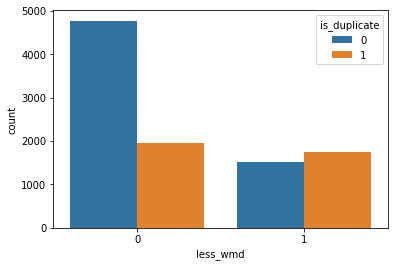

In [140]:
sns.countplot(x='less_wmd', hue='is_duplicate', data=df)

* **from the above graph we can clearly see that questions are more likely to be 'not duplicate' when they are not in 'less_wmd' range
** 

In [141]:
df.shape

(9999, 22)

In [142]:
df.drop(df[df.isnull().any(axis=1)].index,inplace=True)

In [143]:
df.shape

(9999, 22)

In [144]:
df.head()

,Unnamed: 0,Unnamed: 0.1,id,qid1,qid2,question1,question2,is_duplicate,wmdistance,len_q1,...,len_char_q1,len_char_q2,len_word_q1,len_word_q2,common_words,fuzz_qratio,fuzz_WRatio,fuzz_partial_ratio,fuzz_token_sort_ratio,less_wmd
0,0,0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,0.109718,65,...,19,19,14,12,11,93,95,100,93,1
1,1,1,1,3,4,What is the story of Kohinoor KohiNoor Diamond,What would happen if the Indian government sto...,0,0.345145,46,...,17,25,8,13,4,64,86,70,62,0
2,2,2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,0.241202,72,...,24,23,14,10,4,54,63,53,66,0
3,3,3,3,7,8,Why am I mentally very lonely How can I solve it,Find the remainder when math2324math is divide...,0,0.552092,48,...,18,18,11,9,0,35,35,31,35,0
4,4,4,4,9,10,Which one dissolve in water quikly sugar salt ...,Which fish would survive in salt water,0,0.312057,73,...,23,17,13,7,4,45,86,55,47,0


**Here are all the available features to be considered**

In [145]:
f=['wmdistance','less_wmd','len_q1','len_q2','diff_len','len_char_q1','len_char_q2','len_word_q1','len_word_q2','common_words','fuzz_qratio','fuzz_WRatio','fuzz_partial_ratio','fuzz_token_sort_ratio']

**Here are the best set of features**

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[0.0715628  0.03487637 0.06798036 0.07187151 0.05977332 0.06224601
 0.06212656 0.05953759 0.05925749 0.07824996 0.10490717 0.06676574
 0.09314588 0.10769925]


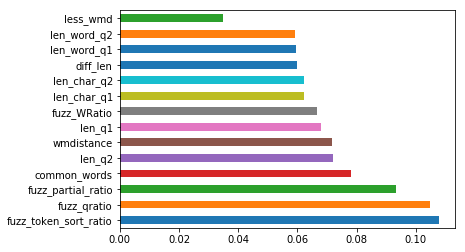

In [146]:
data = df
X = data[f]  #independent columns
y = data['is_duplicate']  #target column i.e price range
from sklearn.ensemble import ExtraTreesClassifier
model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')
plt.show()

In [147]:
print(df[(df['fuzz_token_sort_ratio']<60) & (df['is_duplicate']==1)]['id'].count())
print(df[(df['fuzz_token_sort_ratio']<70) & (df['is_duplicate']==1)]['id'].count())
print(df[(df['fuzz_token_sort_ratio']<80) & (df['is_duplicate']==1)]['id'].count())
print(df[(df['fuzz_token_sort_ratio']<90) & (df['is_duplicate']==1)]['id'].count())
print(df[(df['fuzz_token_sort_ratio']<100) & (df['is_duplicate']==1)]['id'].count())

705
1642
2541
3264
3684


In [857]:
fe=['diff_len','common_words','fuzz_qratio','fuzz_WRatio','fuzz_partial_ratio','fuzz_token_sort_ratio']

In [858]:
X=df[fe]
y=df['is_duplicate']
print(X.shape)

(9999, 6)


In [859]:
X.head()

,diff_len,common_words,fuzz_qratio,fuzz_WRatio,fuzz_partial_ratio,fuzz_token_sort_ratio
0,9,11,93,95,100,93
1,-37,4,64,86,70,62
2,14,4,54,63,53,66
3,-7,0,35,35,31,35
4,35,4,45,86,55,47


In [890]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [891]:
clf2=xgb.XGBClassifier(objective ='reg:linear', colsample_bytree = 0.75, learning_rate = 0.089,
                max_depth = 8, alpha = 10, n_estimators = 10)

In [892]:
clf=DecisionTreeClassifier(random_state=1)

In [893]:
clf2.fit(X_train,y_train)

[18:58:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBClassifier(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.75, gamma=0,
              learning_rate=0.089, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=None, n_estimators=10, n_jobs=1,
              nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
              subsample=1, verbosity=1)

In [894]:
pred=clf2.predict(X_test)
pred

array([0, 0, 1, ..., 0, 1, 1])

In [895]:
accuracy_score(pred,y_test)

0.7076666666666667

**On conducting some tests on the dataset, the changes in the accuracy of the model with respect to the features and different parameters for the classifiers were as follows**

1 ) Xgboost with parameters (objective ='reg:linear', colsample_bytree = 0.75, learning_rate = 0.1,
                max_depth = 11, alpha = 10, n_estimators = 10)
	and features fe=['diff_len','common_words','fuzz_qratio','fuzz_WRatio','fuzz_partial_ratio','fuzz_token_sort_ratio','wmdistance','less_wmd']
    gave         
    accuracy = 70.7%

2 ) Xgboost with parameters (objective ='reg:linear', colsample_bytree = 0.75, learning_rate = 0.1,
                max_depth = 9, alpha = 10, n_estimators = 10)
	and features fe=['diff_len','common_words','fuzz_qratio','fuzz_WRatio','wmdistance','less_wmd']
	gave        
    accuracy = 69.7%

3 )  Xgboost with parameters (objective ='reg:linear', colsample_bytree = 0.6, learning_rate = 0.1,
                max_depth = 8, alpha = 10, n_estimators = 10)
	and features fe=['diff_len','common_words','fuzz_qratio','fuzz_WRatio','fuzz_partial_ratio','fuzz_token_sort_ratio','less_wmd']
	gave      
    accuracy = 70.1%

4 ) Xgboost with parameters (objective ='reg:linear', colsample_bytree = 0.75, learning_rate = 0.089,
                max_depth = 8, alpha = 10, n_estimators = 10)
	and features fe=['diff_len','common_words','fuzz_qratio','fuzz_WRatio','fuzz_partial_ratio','fuzz_token_sort_ratio']
	gave      
    accuracy = 70.7%

5 ) Xgboost with parameters (objective ='reg:linear', colsample_bytree = 0.8, learning_rate = 0.1,
                max_depth = 8, alpha = 10, n_estimators = 10)
	and features fe=['common_words','fuzz_qratio','fuzz_WRatio','fuzz_partial_ratio','fuzz_token_sort_ratio','wmdistance']
	gave      
    accuracy = 70.3%